In [57]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
raw = pd.read_csv('tr_eikon_eod_data.csv', 
                 index_col = 0, parse_dates = True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [59]:
colnames = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [60]:
data = raw[colnames].dropna()

rets = pd.DataFrame()

for stock in colnames:
    data[f"{stock} ret"] = np.log(data[stock] / data[stock].shift(1))

data.dropna(inplace=True)

for stock in colnames:
    data[f"{stock} dir"] = np.sign(data[f"{stock} ret"]).astype(int)

bins = {}

for stock in colnames:
    mean = data[f'{stock} ret'].mean()
    std = data[f'{stock } ret'].std()
    bins[stock] = [mean - std, mean, mean + std]

features = [] # creating an empty list for storing column names
for stock in colnames:
    for i in range(1,6):
        feat = f'{stock} lag_' + str(i)
        data[feat] = np.digitize(data[f'{stock} ret'].shift(i), bins[stock])
        features.append(feat)

data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,AAPL.O ret,MSFT.O ret,INTC.O ret,AMZN.O ret,GS.N ret,...,AMZN.O lag_1,AMZN.O lag_2,AMZN.O lag_3,AMZN.O lag_4,AMZN.O lag_5,GS.N lag_1,GS.N lag_2,GS.N lag_3,GS.N lag_4,GS.N lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,30.625684,30.960,20.87,134.690,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525,...,3,3,3,3,3,3,3,3,3,3
2010-01-06,30.138541,30.770,20.80,132.250,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,...,2,3,3,3,3,3,3,3,3,3
2010-01-07,30.082827,30.452,20.60,130.000,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,...,0,2,3,3,3,1,3,3,3,3
2010-01-08,30.282827,30.660,20.83,133.520,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093,...,1,0,2,3,3,3,1,3,3,3
2010-01-11,30.015684,30.270,20.95,130.308,171.56,-0.008861,-0.012802,0.005744,-0.024350,-0.015902,...,3,1,0,2,3,0,3,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.150,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,...,1,1,2,2,2,1,1,1,1,1
2018-06-26,184.430000,99.080,49.67,1691.090,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,...,0,1,1,2,2,0,1,1,1,1
2018-06-27,184.160000,97.540,48.76,1660.510,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,...,2,0,1,1,2,2,0,1,1,1


In [61]:
def calculate_rsi(prices, period=14):
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)
    
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

for stock in colnames:
    data[f"{stock} rsi"] = calculate_rsi(data[stock])
    data[f"{stock} rsi"] = data[f"{stock} rsi"].shift(1)

features += [f"{stock} rsi" for stock in colnames]

In [62]:
def moving_average(data, window_short=20, window_long=60):
    """
    Calculate short-term and long-term moving averages.

    Parameters:
    - data: List or array-like object containing the time series data.
    - window_short: Integer specifying the window size for the short-term moving average.
    - window_long: Integer specifying the window size for the long-term moving average.

    Returns:
    - short_ma: List containing the short-term moving averages.
    - long_ma: List containing the long-term moving averages.
    """

    # Calculate short-term moving average
    short_ma = data.rolling(window=window_short).mean()

    # Calculate long-term moving average
    long_ma = data.rolling(window=window_long).mean()

    return short_ma, long_ma

for stock in colnames:
    short, long = moving_average(data[f"{stock} ret"])
    data[f'{stock} SMA'] = np.where(short > long, 1, -1)
    data[f"{stock} SMA"].shift(1)

features += [f"{stock} SMA" for stock in colnames]

feat_data = data.dropna()

feat_data



,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,AAPL.O ret,MSFT.O ret,INTC.O ret,AMZN.O ret,GS.N ret,...,AAPL.O rsi,MSFT.O rsi,INTC.O rsi,AMZN.O rsi,GS.N rsi,AAPL.O SMA,MSFT.O SMA,INTC.O SMA,AMZN.O SMA,GS.N SMA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-26,29.419971,29.50,20.00,119.48,150.88,0.014009,0.006120,-0.015873,-0.006923,-0.026811,...,38.425310,33.717236,43.712849,23.911466,21.680942,-1,-1,-1,-1,-1
2010-01-27,29.697685,29.67,20.24,122.75,151.50,0.009395,0.005746,0.011929,0.027001,0.004101,...,41.837524,36.004601,40.732850,23.212399,19.536903,-1,-1,-1,-1,-1
2010-01-28,28.469972,29.16,19.92,126.03,153.29,-0.042219,-0.017339,-0.015937,0.026370,0.011746,...,46.928375,39.414935,44.243421,33.744011,21.691542,-1,-1,-1,-1,-1
2010-01-29,27.437544,28.18,19.40,125.41,148.72,-0.036938,-0.034185,-0.026451,-0.004932,-0.030266,...,40.340190,38.010393,43.178170,43.438017,18.403318,-1,-1,-1,-1,-1
2010-02-01,27.818544,28.41,19.61,118.87,153.13,0.013791,0.008129,0.010767,-0.053558,0.029222,...,34.504007,29.870130,36.442928,35.173675,17.843679,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.39,50.71,1663.15,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,...,27.164574,43.396226,26.077348,65.777611,39.183902,-1,-1,-1,-1,-1
2018-06-26,184.430000,99.08,49.67,1691.09,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,...,16.036585,32.789855,22.390892,40.836829,33.669549,-1,-1,-1,-1,1
2018-06-27,184.160000,97.54,48.76,1660.51,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,...,23.457476,35.083115,16.787004,48.882494,18.621096,-1,-1,-1,-1,1


                AAPL.O  MSFT.O  INTC.O   AMZN.O    GS.N  AAPL.O ret  \
Date                                                                  
2010-01-26   29.419971   29.50   20.00   119.48  150.88    0.014009   
2010-01-27   29.697685   29.67   20.24   122.75  151.50    0.009395   
2010-01-28   28.469972   29.16   19.92   126.03  153.29   -0.042219   
2010-01-29   27.437544   28.18   19.40   125.41  148.72   -0.036938   
2010-02-01   27.818544   28.41   19.61   118.87  153.13    0.013791   
...                ...     ...     ...      ...     ...         ...   
2018-06-25  182.170000   98.39   50.71  1663.15  221.54   -0.014983   
2018-06-26  184.430000   99.08   49.67  1691.09  221.58    0.012330   
2018-06-27  184.160000   97.54   48.76  1660.51  220.18   -0.001465   
2018-06-28  185.500000   98.63   49.25  1701.45  223.42    0.007250   
2018-06-29  185.110000   98.61   49.71  1699.80  220.57   -0.002105   

            MSFT.O ret  INTC.O ret  AMZN.O ret  GS.N ret  ...  AAPL.O rsi  \

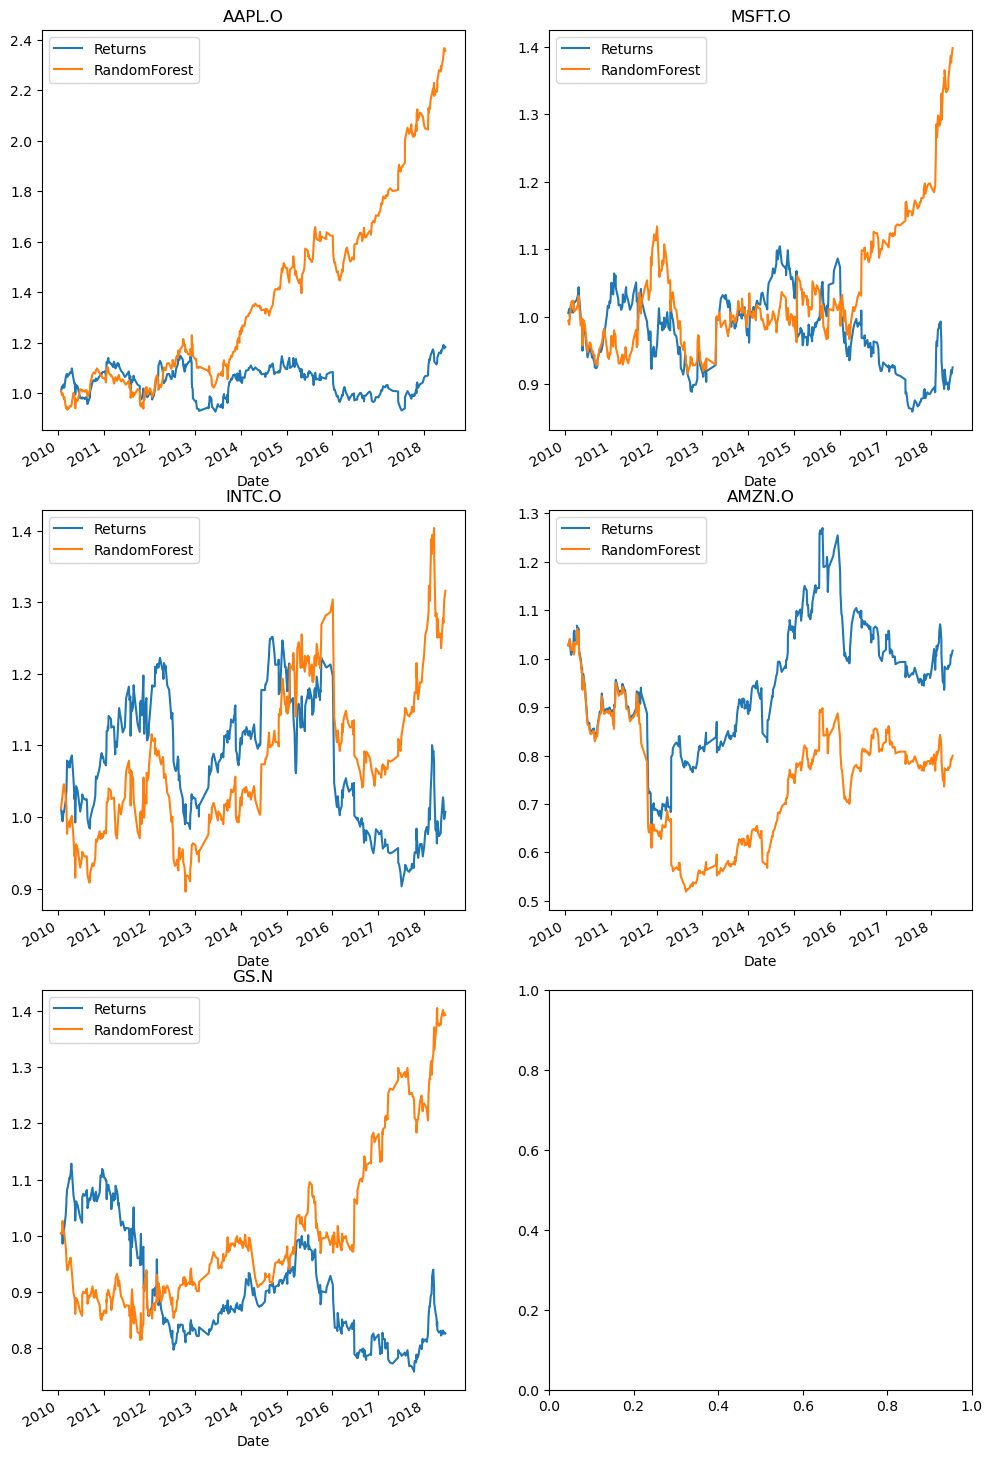

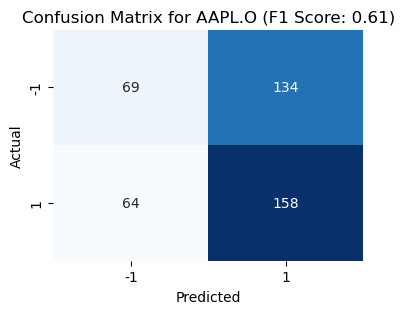

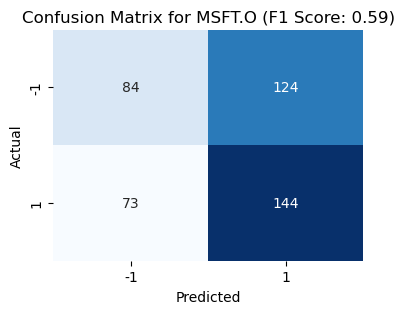

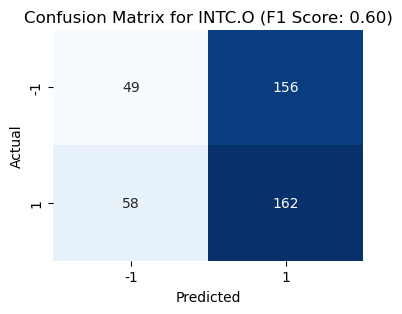

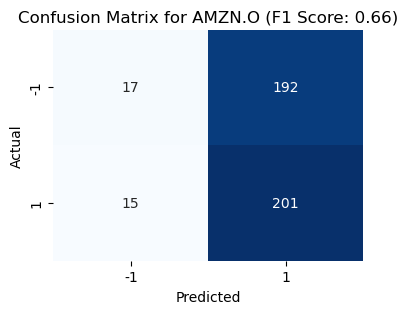

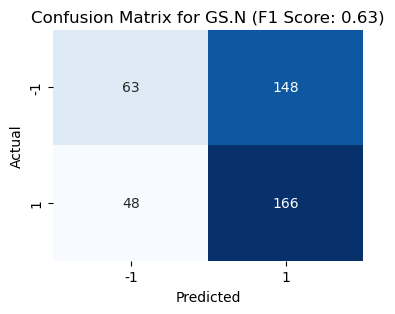

[[ 1 -1  1  1  1]
 [-1 -1 -1  1  1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1  1]
 [-1 -1 -1  1  1]
 [-1  1  1  1  1]]


In [65]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

print(data)
print(data_train)
print("-" * 100)
print(data_test)

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

model.fit(training, training_res)

results = model.predict(testing)

print("-" * 100)
print("Returns:")
print("-" * 100)
print(data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print("-" * 100)
print("RandomForest returns:")
print("-" * 100)
print((results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))
print("-" * 100)

print("-" * 100)
print("False predictions:")
print("-" * 100)
print((results != data_test[[f"{stock} dir" for stock in colnames]]).sum())
print("-" * 100)

print("-" * 100)
print("Total rows:")
print("-" * 100)
print(results.shape[0])
print("-" * 100)

print("-" * 100)
print("Feature importance:")
print("-" * 100)
feature_importances = model.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(features, feature_importances))

# Sort feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importances with corresponding feature names
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature} - Importance: {importance}")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,20))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()

print(results)



In [ ]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

print(data)
print(data_train)
print("-" * 100)
print(data_test)

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

model.fit(training, training_res)

results = model.predict(testing)

print("-" * 100)
print("Returns:")
print("-" * 100)
print(data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print("-" * 100)
print("RandomForest returns:")
print("-" * 100)
print((results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))
print("-" * 100)

print("-" * 100)
print("False predictions:")
print("-" * 100)
print((results != data_test[[f"{stock} dir" for stock in colnames]]).sum())
print("-" * 100)

print("-" * 100)
print("Total rows:")
print("-" * 100)
print(results.shape[0])
print("-" * 100)

print("-" * 100)
print("Feature importance:")
print("-" * 100)
feature_importances = model.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(features, feature_importances))

# Sort feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importances with corresponding feature names
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature} - Importance: {importance}")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,20))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()

print(results)

